# Make datasets for cell locations

In [16]:
# Autorelaod
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import scanpy as sc

os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf
import utils.embeddings_functions as my_embs


config_file="/home/gdallagl/myworkdir/ESMSec/config/config.yaml"
config = mf.load_config(config_file)

mf.set_all_seeds(config["random_seed"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
Seeds set successfully to 42 for random, numpy, and PyTorch (if used).


## Cell location  by Uniprot

Who use as locations annoation?
- **Gene Ontology (cellular component)**:
    - more broad
    - no secreted
- **Subcellular location [CC]**:
    - more specific
    - how to deal wiht isoforms?
    - how to dela with protein that cna be in differt lcoations after some modifications?


In [38]:
# Load unirprot celllar locations
    # ATTENTION: they are alredy checked proteins
df_cl = pd.read_csv(config["data_paths"]["human_proteome_uniprot"])
display(df_cl.head(3))

# Define proteins to use in the follwing analasys
ALLOWED_PROTEINS = set(df_cl.Entry)
print("Number allowed proteins: ", len(ALLOWED_PROTEINS))
print(*list(ALLOWED_PROTEINS)[:10], "...")

,Entry,Reviewed,Gene Names (primary),Gene Names,Organism,Length,Subcellular location [CC],Gene Ontology (cellular component),Sequence,IsIsoform
0,Q8WZ42,reviewed,TTN,TTN,Homo sapiens (Human),34350,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000305|P...,condensed nuclear chromosome [GO:0000794]; cyt...,MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...,False
1,Q8WXI7,reviewed,MUC16,MUC16 CA125,Homo sapiens (Human),14507,SUBCELLULAR LOCATION: Cell membrane; Single-pa...,external side of plasma membrane [GO:0009897];...,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,False
2,Q9H195,reviewed,MUC3B,MUC3B,Homo sapiens (Human),13477,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,Golgi lumen [GO:0005796]; plasma membrane [GO:...,MQLLGLLSILWMLKSSPGATGTLSTATSTSHVTFPRAEATRTALSN...,False


Number allowed proteins:  20210
Q99707 O75445 Q5VZ18 P23919 Q96F45 P21397 A8MPX8 Q96HD1 O75414 P16157 ...


In [39]:
# Load unirpot cell locations anmes
cl_names = pd.read_csv(config["data_paths"]["uniprot_cellular_locations_names"], sep="\t")
STANDARD_LOCATIONS = set(cl_names['Name'].str.lower().str.strip())
print(STANDARD_LOCATIONS)
cl_names

{'lateral cell membrane', 'cilium membrane', 'golgi apparatus', 'secretory vesicle', 'coated pit', 'copii-coated vesicle', 'organellar chromatophore membrane', 'smooth endoplasmic reticulum lumen', 'bleb', 'endoplasmic reticulum', 'chloroplast membrane', 'organellar chromatophore thylakoid membrane', 'host microsome', 'plastid outer membrane', 'caveola', 'target membrane', 'lysosome', 'organellar chromatophore thylakoid', 'cytoskeleton', 'nucleomorph', 'endosome lumen', 'extracellular side', 'gas vesicle', 'cell envelope', 'endoplasmic reticulum-golgi intermediate compartment membrane', 'kinocilium', 'autolysosome membrane', 'flagellum basal body', 'spore wall', 'glycosome membrane', 'preautophagosomal structure membrane', 'vacuole membrane', 'microvillus membrane', 'tight junction', 'acrosome', 'golgi stack lumen', 'spore cortex', 'nucleus membrane', 'trans-golgi network membrane', 'bacterial extracellular vesicle', 'p-body', 'gas vesicle shell', 'trichocyst', 'host mitochondrion memb

,Subcellular location ID,Name,Category,Gene Ontologies,Is a
0,SL-0476,A band,Cellular component,GO:0031672:A band,NaN
1,SL-0002,Acidocalcisome,Cellular component,GO:0020022:acidocalcisome,NaN
2,SL-0316,Acidocalcisome lumen,Cellular component,GO:0033985:acidocalcisome lumen,NaN
3,SL-0003,Acidocalcisome membrane,Cellular component,GO:0033102:acidocalcisome membrane,SL-0162; Membrane; LOCATION
4,SL-0007,Acrosome,Cellular component,GO:0001669:acrosomal vesicle,SL-0244; Secretory vesicle; LOCATION
...,...,...,...,...,...
559,SL-0549,Zymogen granule membrane,Cellular component,GO:0042589:zymogen granule membrane,SL-0245; Secretory vesicle membrane; LOCATION
560,SL-0067,cis-Golgi network,Cellular component,GO:0005801:cis-Golgi network,NaN
561,SL-0068,cis-Golgi network membrane,Cellular component,GO:0033106:cis-Golgi network membrane,SL-0134; Golgi apparatus membrane; LOCATION
562,SL-0266,trans-Golgi network,Cellular component,GO:0005802:trans-Golgi network,NaN


### Location: *Gene Ontology (cellular component)*

,Entry,Reviewed,Gene Names (primary),Gene Names,Organism,Length,Subcellular location [CC],Gene Ontology (cellular component),Sequence,IsIsoform,GO-locations_list,GO-locations,GO_n_locations
0,Q8WZ42,reviewed,TTN,TTN,Homo sapiens (Human),34350,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000305|P...,condensed nuclear chromosome [go:0000794]; cyt...,MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...,False,"{m band, cytosol, striated muscle thin filamen...","{m band, cytosol, striated muscle thin filamen...",9
1,Q8WXI7,reviewed,MUC16,MUC16 CA125,Homo sapiens (Human),14507,SUBCELLULAR LOCATION: Cell membrane; Single-pa...,external side of plasma membrane [go:0009897];...,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,False,"{plasma membrane, golgi lumen, vesicle, extrac...","{golgi lumen, plasma membrane, vesicle, extrac...",5
2,Q9H195,reviewed,MUC3B,MUC3B,Homo sapiens (Human),13477,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,golgi lumen [go:0005796]; plasma membrane [go:...,MQLLGLLSILWMLKSSPGATGTLSTATSTSHVTFPRAEATRTALSN...,False,"{golgi lumen, plasma membrane}","{golgi lumen, plasma membrane}",2
3,Q8NF91,reviewed,SYNE1,SYNE1 C6orf98 KIAA0796 KIAA1262 KIAA1756 MYNE1,Homo sapiens (Human),8797,SUBCELLULAR LOCATION: Nucleus outer membrane {...,cytoplasm [go:0005737]; cytoskeleton [go:00058...,MATSRGASRCPRDIANVMQRLQDEQEIVQKRTFTKWINSHLAKRKP...,False,"{nucleolus, nucleoplasm, cytoplasm, postsynapt...","{nucleolus, nucleoplasm, cytoplasm, postsynapt...",14


257    Q5S007
Name: Entry, dtype: object

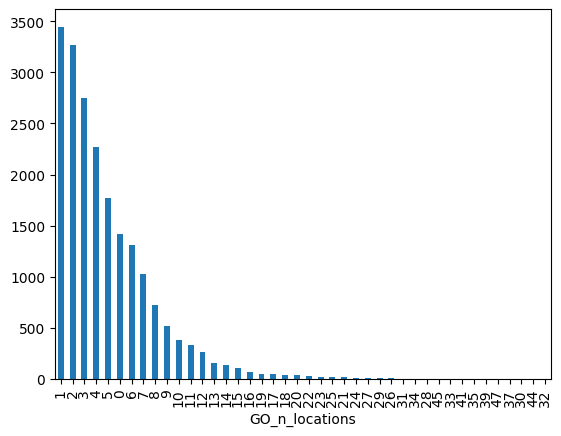

In [40]:
df_cl["Gene Ontology (cellular component)"] = df_cl["Gene Ontology (cellular component)"].fillna(value="")
df_cl["Gene Ontology (cellular component)"] = df_cl["Gene Ontology (cellular component)"].str.lower()

locations = []

for locs in df_cl["Gene Ontology (cellular component)"]:

    #print(locs)

    if locs == "":
        locations.append(set())
        continue

    locs = locs.split("; ")
    #print(locs)

    locs = [l.split(" [")[0] for l in locs]

    #print(locs)

    locations.append(set(locs))

df_cl["GO-locations_list"] = locations
df_cl["GO-locations"] = df_cl["GO-locations_list"].apply(set) 
df_cl["GO_n_locations"] = df_cl["GO-locations"].apply(len)

display(df_cl.head(4))

df_cl["GO_n_locations"].value_counts().plot(kind="bar", logy=False)

# high count protein?
df_cl[df_cl["GO_n_locations"] == 45].Entry

### Location: *Uniprot CC*

,Entry,Reviewed,Gene Names (primary),Gene Names,Organism,Length,Subcellular location [CC],Gene Ontology (cellular component),Sequence,IsIsoform,GO-locations_list,GO-locations,GO_n_locations,Uniprot-locations_list,has_isoforms,Uniprot-locations,Uniprot_n_locations
0,Q8WZ42,reviewed,TTN,TTN,Homo sapiens (Human),34350,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000305|P...,condensed nuclear chromosome [go:0000794]; cyt...,MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...,False,"{m band, cytosol, striated muscle thin filamen...","{m band, cytosol, striated muscle thin filamen...",9,"[cytoplasm, nucleus]",False,"{cytoplasm, nucleus}",2
1,Q8WXI7,reviewed,MUC16,MUC16 CA125,Homo sapiens (Human),14507,SUBCELLULAR LOCATION: Cell membrane; Single-pa...,external side of plasma membrane [go:0009897];...,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,False,"{plasma membrane, golgi lumen, vesicle, extrac...","{golgi lumen, plasma membrane, vesicle, extrac...",5,"[cell membrane, secreted, extracellular space]",False,"{secreted, extracellular space, cell membrane}",3
2,Q9H195,reviewed,MUC3B,MUC3B,Homo sapiens (Human),13477,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,golgi lumen [go:0005796]; plasma membrane [go:...,MQLLGLLSILWMLKSSPGATGTLSTATSTSHVTFPRAEATRTALSN...,False,"{golgi lumen, plasma membrane}","{golgi lumen, plasma membrane}",2,[membrane],False,{membrane},1
3,Q8NF91,reviewed,SYNE1,SYNE1 C6orf98 KIAA0796 KIAA1262 KIAA1756 MYNE1,Homo sapiens (Human),8797,SUBCELLULAR LOCATION: Nucleus outer membrane {...,cytoplasm [go:0005737]; cytoskeleton [go:00058...,MATSRGASRCPRDIANVMQRLQDEQEIVQKRTFTKWINSHLAKRKP...,False,"{nucleolus, nucleoplasm, cytoplasm, postsynapt...","{nucleolus, nucleoplasm, cytoplasm, postsynapt...",14,"[nucleus outer membrane, nucleus, nucleus enve...",True,"{cytoplasm, sarcomere, golgi apparatus, cytosk...",8


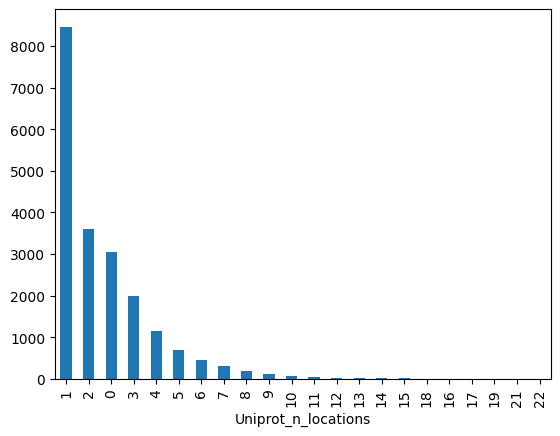

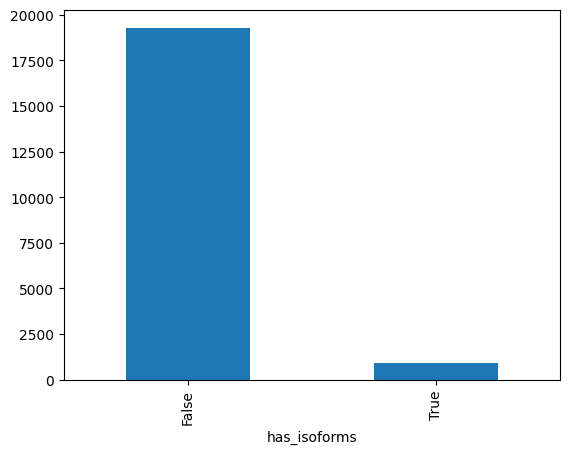

5592    Q06787
Name: Entry, dtype: object

In [41]:
def extract_locations(text):
    """
    Extract ALL subcellular locations from UniProt format.
    
    Returns:
        tuple: (locations_list, has_multiple_forms_bool)
    """
    locations = []
    has_multiple_forms = False
    
    # Check if text is empty
    if pd.isna(text) or not text.strip():
        return locations, has_multiple_forms
    
    # Check if contains subcellular location annotation
    if 'SUBCELLULAR LOCATION: ' not in text:
        return locations, has_multiple_forms
    
    # Remove evidence codes {}
    text = re.sub(r' \{[^}]+\}', '', text)
    
    # Split by 'SUBCELLULAR LOCATION: ' (first element is always empty)
    macros = text.split('SUBCELLULAR LOCATION: ')[1:]
    
    for macro in macros:
        # Remove notes (including those in parentheses)
        macro = macro.split(". Note")[0]
        macro = re.sub(r'\. Note=.*', '', macro, flags=re.IGNORECASE)
        
        # Remove isoform labels [Isoform X]:
        parts = re.split(r"\[[^\]]*\]:\s*", macro)
        macro = parts[-1]
        
        # If split happened, we have multiple forms
        if len(parts) > 1:
            has_multiple_forms = True
        
        # Split by period (different location statements)
        hierarchies = macro.split(". ")
        
        for h in hierarchies:
            # Remove qualifiers after ";"
            h = h.split(";")[0]
            
            # Split hierarchy by ","
            parts = h.split(", ")
            
            # Add to locations
            locations.extend(parts)
    
    # Clean up locations and filter against standard list
    cleaned_locations = []
    for loc in locations:
        
        loc = loc.strip().rstrip('.')
        
        # FILTER: Only keep if it matches a standard location
        if STANDARD_LOCATIONS and loc.lower() not in STANDARD_LOCATIONS:
            continue
        
        cleaned_locations.append(loc.lower())
    
    return cleaned_locations, has_multiple_forms



df_cl[['Uniprot-locations_list', 'has_isoforms']] = df_cl['Subcellular location [CC]'].apply(
    lambda x: pd.Series(extract_locations(x))
)

df_cl['Uniprot-locations'] = df_cl['Uniprot-locations_list'].apply(set)
df_cl['Uniprot_n_locations'] = df_cl['Uniprot-locations'].apply(len)


display(df_cl.head(4))

df_cl["Uniprot_n_locations"].value_counts().plot(kind="bar", logy=False); plt.show()
df_cl["has_isoforms"].value_counts().plot(kind="bar", logy=False); plt.show()


# high count protein?
df_cl[df_cl["Uniprot_n_locations"] == 22].Entry

In [42]:
df_cl[df_cl.Entry == "P13727"]#["Uniprot-locations"].to_list()

,Entry,Reviewed,Gene Names (primary),Gene Names,Organism,Length,Subcellular location [CC],Gene Ontology (cellular component),Sequence,IsIsoform,GO-locations_list,GO-locations,GO_n_locations,Uniprot-locations_list,has_isoforms,Uniprot-locations,Uniprot_n_locations
16004,P13727,reviewed,PRG2,PRG2 MBP,Homo sapiens (Human),222,SUBCELLULAR LOCATION: [Bone marrow proteoglyca...,collagen-containing extracellular matrix [go:0...,MKLPLLLALLFGAVSALHLRSETSTFETPLGAKTLPEDEETPEQEM...,False,"{ficolin-1-rich granule lumen, collagen-contai...","{extracellular region, ficolin-1-rich granule ...",5,"[secreted, cytoplasmic vesicle, secretory vesi...",True,"{secretory vesicle, cytoplasmic vesicle, secre...",3


In [43]:
# save processed df
df_cl.to_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/uniprotkb_reviewed_cellular_locations_formatted.csv", index=False)

## Create dataset Location

- Need to pass resulting csv to `02_makedataset.ipynb`
- Take also prot with multiple locations

- 02_make_dataset is based on gene, so we need to maitian them

### Choose location col to use

All locations:  245
{'lateral cell membrane', 'chromosome', 'synaptic vesicle membrane', 'h zone', 'recycling endosome', 'cilium membrane', 'golgi apparatus', 'nuclear pore complex', 'secretory vesicle', 'pseudopodium membrane', 'coated pit', 'gap junction', 'smooth endoplasmic reticulum membrane', 'lamellipodium membrane', 'copii-coated vesicle', 'adherens junction', 'filopodium', 'centriole', 'bleb', 'endoplasmic reticulum', 'myofibril', 'dynein axonemal particle', 'phagosome membrane', 'caveola', 'spindle', 'phagocytic cup', 'surface film', 'vacuole', 'presynapse', 'chromaffin granule', 'extracellular matrix', 'lysosome', 'cytoskeleton', 'endosome lumen', 'stereocilium membrane', 'endoplasmic reticulum-golgi intermediate compartment membrane', 'cilium basal body', 'nucleus', 'kinocilium', 'extracellular vesicle membrane', 'autolysosome membrane', 'acrosome inner membrane', 'flagellum basal body', 'zymogen granule', 'nucleolus fibrillar center', 'preautophagosomal structure membrane'

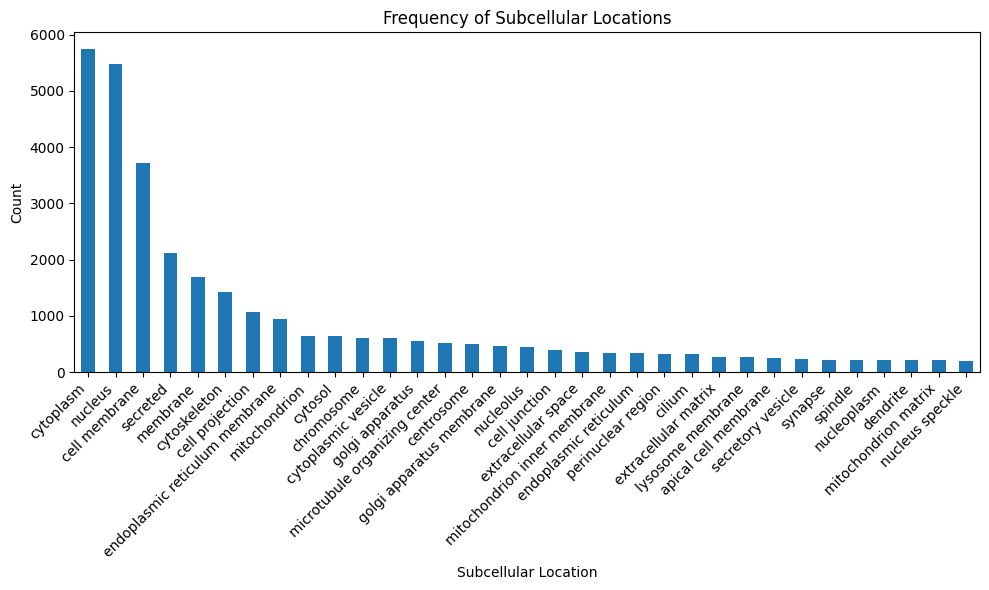

In [116]:
# Hyperparametrs for this dataset
ANNOTATION_TYPE = "Uniprot-locations" # GO, Uniprot
REMOVE_ISOFORMS = True   # proteins that have diffretn comparnts based on location
MIN_PROTEIN_PER_LOCATION = 200
LOCATION = "secreted"#"nucleus speckle"
REMOVE_MULTIPLE_LOCATIONS = True # pos class avoid proteins that are in multiple locations + put the proteisn that have more in ambighous
#############################################

# All locations
all_locations = set().union(*df_cl[ANNOTATION_TYPE])
print("All locations: ", len(all_locations))
print(all_locations)

# How porteins per location
all_locations_list = [loc for locs in df_cl[ANNOTATION_TYPE] for loc in locs]
len(all_locations_list)
counts = pd.Series(all_locations_list).value_counts()
counts = counts[counts>=MIN_PROTEIN_PER_LOCATION]
allowed_locations = set(counts.index)
print("Allowed locations: ", len(allowed_locations))
print(allowed_locations)

plt.figure(figsize=(10, 6))
counts.plot(kind="bar")
plt.title("Frequency of Subcellular Locations")
plt.xlabel("Subcellular Location")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [117]:
# Filter protein that have this location
df_location = df_cl[df_cl[ANNOTATION_TYPE].apply(lambda x: len(set([LOCATION]).intersection(x)) != 0 )].copy().rename(columns={"Gene Names (primary)": "gene", "Entry": "tmp_protein"})

# Add columns
df_location["geneset_count"] = 1 # costant (sample with same probavility)
df_location["definitive_positive"] = "positive"

if REMOVE_MULTIPLE_LOCATIONS:
    multiple_location_proteins = df_location[df_location[ANNOTATION_TYPE].apply(len) > 1 ].gene.to_list()
    df_location.loc[df_location.gene.isin(multiple_location_proteins), "definitive_positive"] = "ambiguous"


if REMOVE_ISOFORMS:
    df_location.loc[df_location.has_isoforms == True, "definitive_positive"] = "ambiguous"


# Slect col
df_location = df_location[["gene", "definitive_positive", "geneset_count", ANNOTATION_TYPE, "tmp_protein"]]


display(df_location)
df_location["definitive_positive"].value_counts()

,gene,definitive_positive,geneset_count,Uniprot-locations,tmp_protein
1,MUC16,ambiguous,1,"{secreted, extracellular space, cell membrane}",Q8WXI7
5,MUC19,positive,1,{secreted},Q7Z5P9
15,MUC5B,positive,1,{secreted},Q9HC84
16,MUC5AC,positive,1,{secreted},P98088
17,HMCN1,ambiguous,1,"{cytoplasm, basement membrane, extracellular m...",Q96RW7
...,...,...,...,...,...
20183,MTRNR2L11,ambiguous,1,"{cytoplasm, secreted}",S4R3Y5
20188,IGHJ1,ambiguous,1,"{cell membrane, secreted}",A0A0C4DH62
20193,MT-RNR1,ambiguous,1,"{mitochondrion, nucleus, secreted}",A0A0C5B5G6
20206,IGKJ1,ambiguous,1,"{cell membrane, secreted}",A0A0A0MT89


definitive_positive
ambiguous    1142
positive      971
Name: count, dtype: int64

In [55]:
df_location[df_location["gene"].duplicated()]
df_location[df_location.Entry == "P13727"]#["Uniprot-locations"].to_list()

,gene,definitive_positive,geneset_count,Uniprot-locations,Entry


In [75]:
# Save
df_location.to_csv(f"/home/gdallagl/myworkdir/ESMSec/data/cell_location/{LOCATION.replace(' ', '-')}_{ANNOTATION_TYPE}_02_positive_proteins.csv", index=False)

### Visualise embeddings

In [77]:
adata = sc.read_h5ad("/home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/entire_reviewed_uniprot_facebook-esm2_t36_3B_UR50D_cls.h5ad")
adata

AnnData object with n_obs × n_vars = 20405 × 1000
    obs: 'protein', 'gene', 'Reviewed', 'Gene Names', 'Organism', 'Length', 'Protein names', 'sequence', 'truncated_sequence'
    uns: 'X_umap_all', 'X_umap_pca', 'neighbors_all', 'neighbors_pca', 'pca', 'vocabulary'
    obsm: 'X_all', 'X_pca', 'X_umap_all', 'X_umap_pca'
    layers: 'attention_mask'
    obsp: 'neighbors_all_connectivities', 'neighbors_all_distances', 'neighbors_pca_connectivities', 'neighbors_pca_distances'

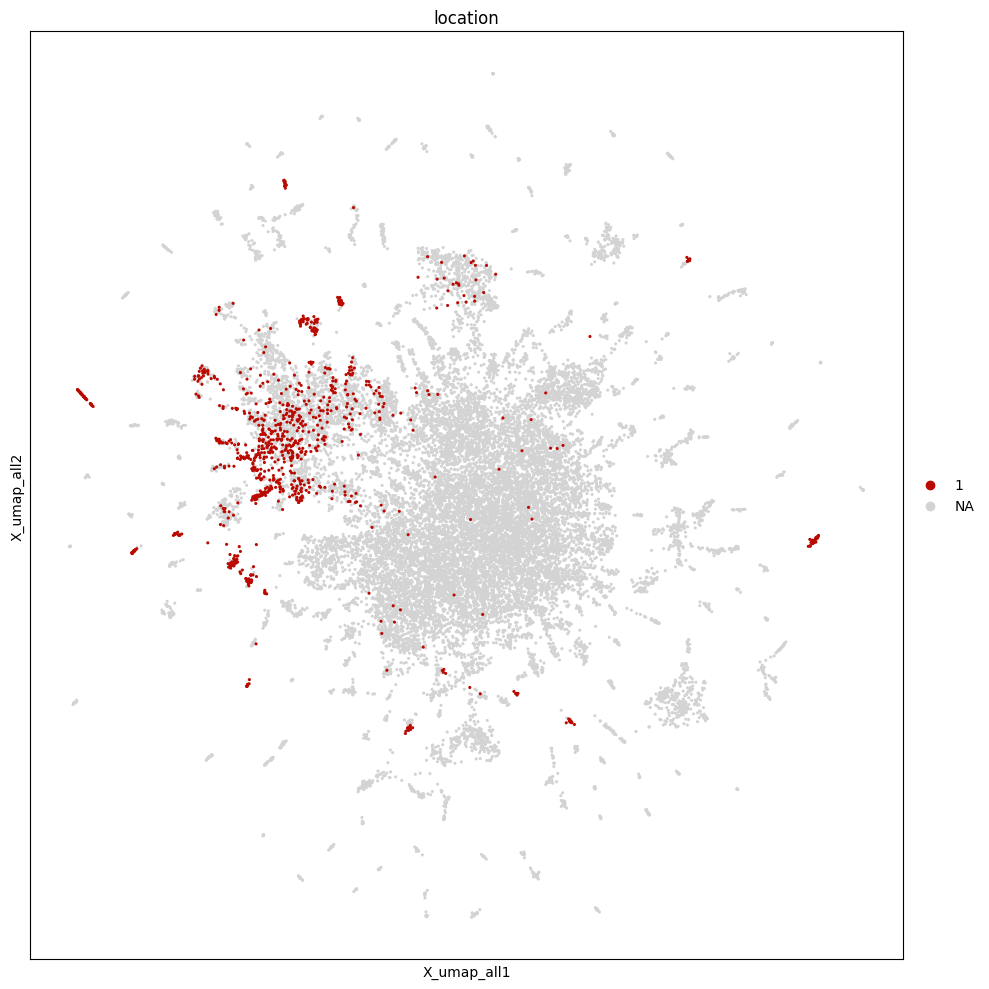

In [118]:

# Mark proteins
protein_in_location = df_location[df_location.definitive_positive=="positive"].tmp_protein.to_list()
adata.obs[f"location"] = [1 if p in protein_in_location else None for p in adata.obs.protein]
adata.obs[f"location"] = pd.Categorical(
    adata.obs[f"location"],
    categories=[1],  # 0 plotted first (bottom), 1 on top
    ordered=True
)

fig, axes = my_embs.plot_embeddings(
    adata,
    basis=["X_umap_all"],
    color=["location"],
    #title=[col for col in adata.obs.columns if "loc" in col],
    size=[20],
    palette=[["#BA0900"]],
    ncols=1,
    figsize=(10, 10),
)
plt.show()

Calculating Neightbors...
Calculating Umaps...


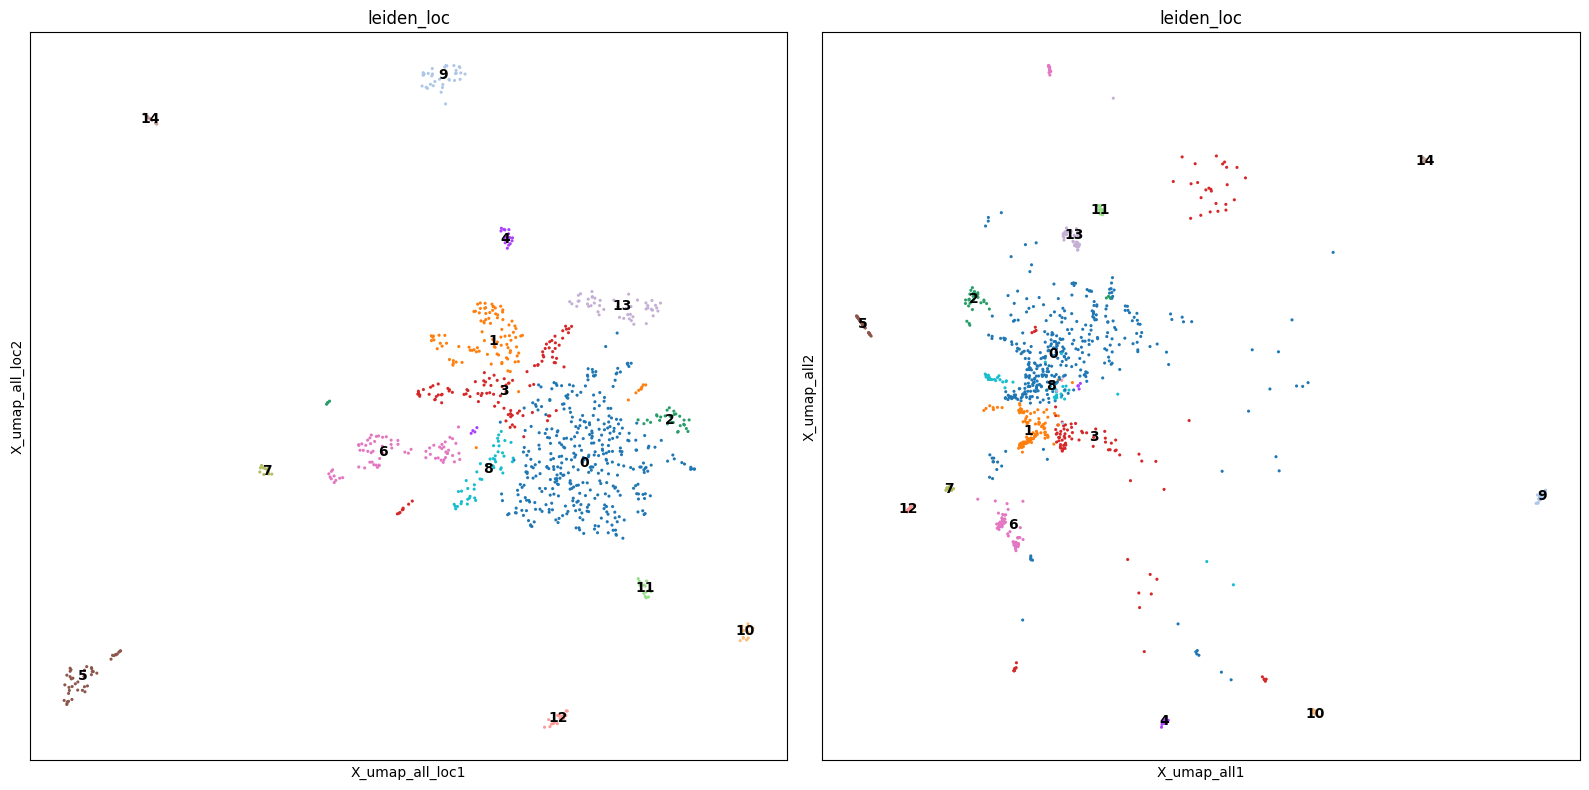

In [119]:
adata_location = adata[adata.obs.protein.isin(protein_in_location)].copy()


# --- Neighbors ---
print("Calculating Neightbors...")
sc.pp.neighbors(adata_location, use_rep="X_all", n_neighbors=10, key_added="neighbors_all_loc")# Use raw adata.X

# --- UMAPs ---
print("Calculating Umaps...")
sc.tl.umap(adata_location, random_state=42, neighbors_key="neighbors_all_loc", key_added="X_umap_all_loc") # each time overweites X_umap

# --- Liaden ---
sc.tl.leiden(adata_location, resolution=0.3, neighbors_key=f"neighbors_all_loc", key_added=f"leiden_loc", flavor="igraph", n_iterations=2)


fig, axes = my_embs.plot_embeddings(
    adata_location,
    basis=[f"X_umap_all_loc", "X_umap_all"],
    color=[f"leiden_loc"],
    #title=["UMAP (neighbors from all features)"],
    size=[20],
    #palette=[big_palette],
    ncols=2,  # 2 columns, 2 rows
    figsize=(16, 8), 
    legend_loc=['on data'],
)
plt.show()


In [123]:
uniprot_ids = adata_location.obs[adata_location.obs["leiden_loc"] == "5"].protein
print(uniprot_ids.to_list())

print(f"{'UniProt ID':<12} {'Gene':<12} {'Function'}")
print("="*100)
for uid in uniprot_ids[:20]:
    gene, func = mf.get_uniprot_info(uid)
    print(f"{uid:<12} {gene:<12} {func}")
print("...")

['O00175', 'O00585', 'O00626', 'O14625', 'O15444', 'O15467', 'O43927', 'O95715', 'P02775', 'P02776', 'P02778', 'P09341', 'P10145', 'P10147', 'P10720', 'P13236', 'P13500', 'P13501', 'P16619', 'P19875', 'P19876', 'P22362', 'P42830', 'P47992', 'P48061', 'P51671', 'P55773', 'P55774', 'P78556', 'P80075', 'P80098', 'P80162', 'Q07325', 'Q16627', 'Q16663', 'Q8NHW4', 'Q92583', 'Q99616', 'Q99731', 'Q9NRJ3', 'Q9UBD3', 'Q9Y258', 'Q9Y4X3']
UniProt ID   Gene         Function
O00175       CCL24 {ECO:0000312|HGNC:HGNC:10623} Chemotactic for resting T-lymphocytes, and eosinophils (PubMed:9104803, PubMed:9365122). Has lower chemotactic activity for neutrophils but none fo...
O00585       CCL21        Inhibits hemopoiesis and stimulates chemotaxis. Chemotactic in vitro for thymocytes and activated T-cells, but not for B-cells, macrophages, or neu...
O00626       CCL22        May play a role in the trafficking of activated/effector T- lymphocytes to inflammatory sites and other aspects of activated T- lym

# CD-CODE Cell condensates

In [41]:
# Load Allowed proteins (reviewed unirpot)
uniprot = pd.read_csv(config["data_paths"]["human_proteome_uniprot"])

# Rename
#uniprot = uniprot[["Entry", "Sequence"]].rename(columns={"Entry": "protein", "Sequence": "sequence"})

uniprot

,Entry,Reviewed,Gene Names (primary),Gene Names,Organism,Length,Subcellular location [CC],Gene Ontology (cellular component),Sequence,IsIsoform
0,Q8WZ42,reviewed,TTN,TTN,Homo sapiens (Human),34350,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000305|P...,condensed nuclear chromosome [GO:0000794]; cyt...,MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...,False
1,Q8WXI7,reviewed,MUC16,MUC16 CA125,Homo sapiens (Human),14507,SUBCELLULAR LOCATION: Cell membrane; Single-pa...,external side of plasma membrane [GO:0009897];...,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,False
2,Q9H195,reviewed,MUC3B,MUC3B,Homo sapiens (Human),13477,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,Golgi lumen [GO:0005796]; plasma membrane [GO:...,MQLLGLLSILWMLKSSPGATGTLSTATSTSHVTFPRAEATRTALSN...,False
3,Q8NF91,reviewed,SYNE1,SYNE1 C6orf98 KIAA0796 KIAA1262 KIAA1756 MYNE1,Homo sapiens (Human),8797,SUBCELLULAR LOCATION: Nucleus outer membrane {...,cytoplasm [GO:0005737]; cytoskeleton [GO:00058...,MATSRGASRCPRDIANVMQRLQDEQEIVQKRTFTKWINSHLAKRKP...,False
4,P20929,reviewed,NEB,NEB,Homo sapiens (Human),8525,"SUBCELLULAR LOCATION: Cytoplasm, myofibril, sa...",actin cytoskeleton [GO:0015629]; cytosol [GO:0...,MADDEDYEEVVEYYTEEVVYEEVPGETITKIYETTTTRTSDYEQSE...,False
...,...,...,...,...,...,...,...,...,...,...
20205,A0A0A0MT78,reviewed,TRBJ2-7,TRBJ2-7,Homo sapiens (Human),15,SUBCELLULAR LOCATION: Cell membrane {ECO:00003...,T cell receptor complex [GO:0042101],SYEQYFGPGTRLTVT,False
20206,A0A0A0MT89,reviewed,IGKJ1,IGKJ1,Homo sapiens (Human),12,SUBCELLULAR LOCATION: Secreted {ECO:0000303|Pu...,extracellular region [GO:0005576]; immunoglobu...,WTFGQGTKVEIK,False
20207,P0DOY5,reviewed,IGHD1-1,IGHD1-1,Homo sapiens (Human),5,SUBCELLULAR LOCATION: Secreted {ECO:0000303|Pu...,extracellular region [GO:0005576]; immunoglobu...,GTTGT,False
20208,P0DPI4,reviewed,TRBD1,TRBD1,Homo sapiens (Human),4,SUBCELLULAR LOCATION: Cell membrane {ECO:00003...,T cell receptor complex [GO:0042101],GTGG,False


In [68]:
# oad ocndesate locations
df_condensates = pd.read_csv(config["data_paths"]["CD-CODE_condensates_path"], sep="\t")

# Only allowed proteins
df_condensates = df_condensates[df_condensates.uniprotkb_ac.isin(uniprot.Entry.to_list())]

# lower case
df_condensates["condensate_name"] = df_condensates["condensate_name"].str.lower()

# make same strucutre of uniprot
df_condensates = (
    df_condensates.groupby("uniprotkb_ac")["condensate_name"]
    .apply(lambda x: set(x))
    .reset_index(name="condensate_name")
)

# Attach gene information
df_condensates = df_condensates.merge(uniprot[["Entry", "Gene Names (primary)"]], how="inner", left_on="uniprotkb_ac", right_on="Entry")

df_condensates

,uniprotkb_ac,condensate_name,Entry,Gene Names (primary)
0,A0A0U1RRE5,{p-body},A0A0U1RRE5,NBDY
1,A0AV96,"{p-body, stress granule}",A0AV96,RBM47
2,A0FGR8,"{nucleolus, presynaptic clusters and postsynap...",A0FGR8,ESYT2
3,A0FGR9,{nucleolus},A0FGR9,ESYT3
4,A0MZ66,{presynaptic clusters and postsynaptic densities},A0MZ66,SHTN1
...,...,...,...,...
3769,Q9Y6V0,{presynaptic clusters and postsynaptic densities},Q9Y6V0,PCLO
3770,Q9Y6V7,{nucleolus},Q9Y6V7,DDX49
3771,Q9Y6W5,{presynaptic clusters and postsynaptic densities},Q9Y6W5,WASF2
3772,Q9Y6X2,{nuclear speckle},Q9Y6X2,PIAS3


All locations:  327
{'synthetic condensate 000256', 'synthetic condensate 000140', 'junctional condensate', 'synthetic condensate 000287', 'synthetic condensate 000367', 'synthetic condensate 000017', 'synthetic condensate 000087', 'bmp2k condensate', 'synthetic condensate 000370', 'synthetic condensate 000125', 'centrosome', 'synthetic condensate 000222', 'leucocyte nuclear body', 'synthetic condensate 000044', 'rapsn condensate', 'spop/daxx body', 'synthetic condensate 000007', 'synthetic condensate 000090', 'atg4b condensate', 'row 1-specific tip complex condensates', 'synthetic condensate 000089', 'synthetic condensate 000166', 'synthetic condensate 000258', 'synthetic condensate 000204', 'nuage', 'synthetic condensate 000043', 'synthetic condensate 000187', 'lef1/beta-catenin condensate', 'synthetic condensate 000109', 'synthetic condensate 000285', 'synthetic condensate 000096', 'nuclear speckle', 'synthetic condensate 000351', 'chromogranin condensates', 'nuclear pore complex', 

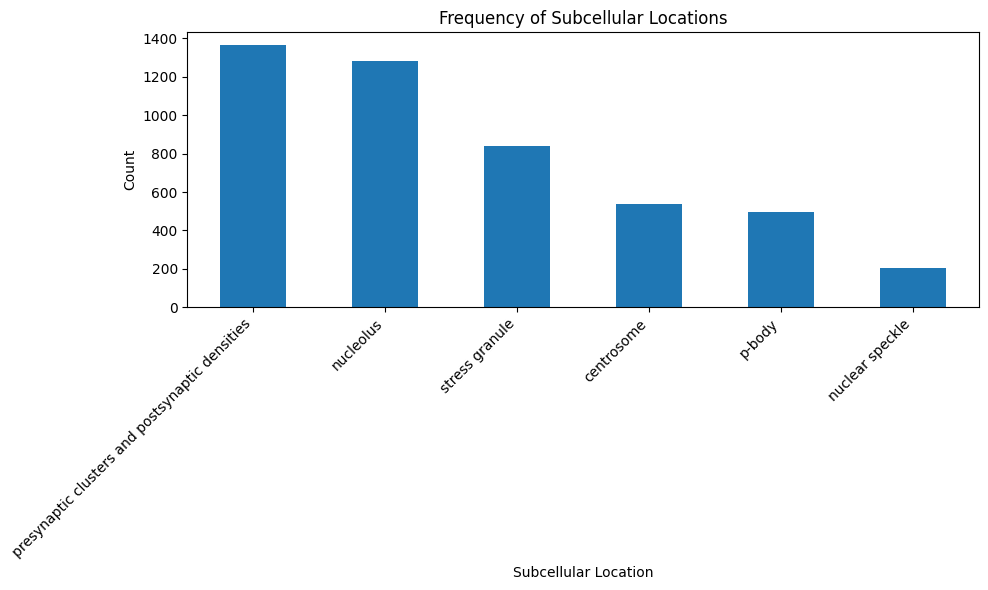

In [70]:
# Hyperparametrs for this dataset
ANNOTATION_TYPE = "condensate_name" # GO, Uniprot
MIN_PROTEIN_PER_LOCATION = 200
LOCATION = "stress granule"#"nucleus speckle"
REMOVE_MULTIPLE_LOCATIONS = True # pos class avoid proteins that are in multiple locations + put the proteisn that have more in ambighous
#############################################

# All locations
all_locations = set().union(*df_condensates[ANNOTATION_TYPE])
print("All locations: ", len(all_locations))
print(all_locations)

# How porteins per location
all_locations_list = [loc for locs in df_condensates[ANNOTATION_TYPE] for loc in locs]
len(all_locations_list)
counts = pd.Series(all_locations_list).value_counts()
counts = counts[counts>=MIN_PROTEIN_PER_LOCATION]
allowed_locations = set(counts.index)
print("Allowed locations: ", len(allowed_locations))
print(allowed_locations)

plt.figure(figsize=(10, 6))
counts.plot(kind="bar")
plt.title("Frequency of Subcellular Locations")
plt.xlabel("Subcellular Location")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [72]:
# Filter protein that have this location
df_location = df_condensates[df_condensates[ANNOTATION_TYPE].apply(lambda x: len(set([LOCATION]).intersection(x)) != 0 )].copy().rename(columns={"Gene Names (primary)": "gene", "Entry": "tmp_protein"})

# Add columns
df_location["geneset_count"] = 1 # costant (sample with same probavility)
df_location["definitive_positive"] = "positive"

if REMOVE_MULTIPLE_LOCATIONS:
    multiple_location_proteins = df_location[df_location[ANNOTATION_TYPE].apply(len) > 1 ].gene.to_list()
    df_location.loc[df_location.gene.isin(multiple_location_proteins), "definitive_positive"] = "ambiguous"


# Slect col
df_location = df_location[["gene", "definitive_positive", "geneset_count", ANNOTATION_TYPE, "tmp_protein"]]


display(df_location)
df_location["definitive_positive"].value_counts()

,gene,definitive_positive,geneset_count,condensate_name,tmp_protein
1,RBM47,ambiguous,1,"{p-body, stress granule}",A0AV96
5,FAM168B,positive,1,{stress granule},A1KXE4
6,PXDNL,positive,1,{stress granule},A1KZ92
7,MEX3A,ambiguous,1,"{p-body, stress granule}",A1L020
14,CNOT1,ambiguous,1,"{assemblysome, p-body, stress granule}",A5YKK6
...,...,...,...,...,...
3742,MAGED1,ambiguous,1,"{p-body, stress granule}",Q9Y5V3
3749,CLIC4,ambiguous,1,"{centrosome, nucleolus, stress granule}",Q9Y696
3757,STYXL1,positive,1,{stress granule},Q9Y6J8
3758,OAS3,positive,1,{stress granule},Q9Y6K5


definitive_positive
ambiguous    593
positive     248
Name: count, dtype: int64

In [73]:
df_location.to_csv(f"/home/gdallagl/myworkdir/ESMSec/data/cell_location/{LOCATION.replace(' ', '-')}_{ANNOTATION_TYPE}_02_positive_proteins.csv", index=False)